In [72]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import numpy as np
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import maya
from datetime import timedelta

from sklearn import linear_model

plt.rcParams['figure.figsize'] = (15, 9)

In [4]:
df = pd.read_csv('pricing_answers.csv')

In [9]:
# add hours_left column

def to_hours(td):
    return round(td.total_seconds() / 3600)

def calculate_hours_left(df):
    """returns: dataframe with added column which contains hours before end"""
    df['hours_left'] = (df['event_finished_at'].apply(maya.parse).apply(maya.MayaDT.datetime) -
                        df['answer_created_at'].apply(maya.parse).apply(maya.MayaDT.datetime)).apply(to_hours)
    return df

df = calculate_hours_left(df)
df = df.sort_values('hours_left')

In [8]:
# filter out time travellers

df = df[df['hours_left'] >= 0]

In [10]:
# pick one event to work with
event_id = "bf8aa2ad-4ecb-4e5c-bb9d-a9b095a1ccc6"
event = df.groupby('event_id').get_group(event_id)

In [32]:
# calculate baseline 

event['baseline_min'] = event['prediction_min'].mean()
event['baseline_max'] = event['prediction_max'].mean()

In [33]:
# normalize data

def norm_by(df, what_to, by):
    by = df[by].copy()
    for name in what_to:
        df[name] = (df[name] - by.mean()) / (by.max() - by.min())
    
    return df

norm_event_min = event[['prediction_min', 'real_min', 'hours_left']]
norm_event_min = norm_by(norm_event_min, ['prediction_min', 'real_min'], 'prediction_min')

norm_event_max = event[['prediction_max', 'real_max', 'hours_left']]
norm_event_max = norm_by(norm_event_max, ['prediction_max', 'real_max'], 'prediction_max')

In [36]:
# plot linear regression on prediction by hours left

def get_regression(event, to_fit, column_name):
    regr = linear_model.LinearRegression()

    hours_reshaped = event.hours_left.reshape(len(event.hours_left), 1)

    regr.fit(hours_reshaped, event[to_fit])

    y = event.hours_left * regr.coef_ + regr.intercept_

    event[column_name] = y
    
    return event

norm_event_min = get_regression(norm_event_min, 'prediction_min', 'regression_min')
norm_event_max = get_regression(norm_event_max, 'prediction_max', 'regression_max')

In [40]:
# assign weights based on regression

def get_weights_min(event):
    event['weight_min'] = 1 - (event['regression_min'] - event['real_min']) ** 2
    return event

def get_weights_max(event):
    event['weight_max'] = 1 - (event['regression_max'] - event['real_max']) ** 2
    return event

norm_event_min = get_weights_min(norm_event_min)
event['weight_min'] = norm_event_min['weight_min']

norm_event_max = get_weights_max(norm_event_max)
event['weight_max'] = norm_event_max['weight_max']

In [41]:
# calculate weigthed average 

def weighted_average(event, weight, value):
    return (event[value] * event[weight]).sum() / event[weight].sum()

event['weighted_min'] = weighted_average(event, 'weight_min', 'prediction_min')
event['weighted_max'] = weighted_average(event, 'weight_max', 'prediction_max')

In [31]:
print(event['baseline_min'].mean())
print(event['weighted_min'].mean())
print(event['real_min'].mean())

2245.69
2245.9377525
2257.25


In [68]:
from visualise import plot_ticker

# make predictions for every event in ticker
ticker_id = "c5e2ca55-3606-40ad-aae5-55be180a7de5"
ticker = df.groupby('ticker_id').get_group(ticker_id)


def predict(event):
    """add a column with prediction"""
    event['baseline_min'] = event['prediction_min'].mean()
    event['baseline_max'] = event['prediction_max'].mean()
    norm_event_min = event[['prediction_min', 'real_min', 'hours_left']]
    norm_event_min = norm_by(norm_event_min, ['prediction_min', 'real_min'], 'prediction_min')

    norm_event_max = event[['prediction_max', 'real_max', 'hours_left']]
    norm_event_max = norm_by(norm_event_max, ['prediction_max', 'real_max'], 'prediction_max')
    
    norm_event_min = get_regression(norm_event_min, 'prediction_min', 'regression_min')
    norm_event_max = get_regression(norm_event_max, 'prediction_max', 'regression_max')
    
    norm_event_min = get_weights_min(norm_event_min)
    event['weight_min'] = norm_event_min['weight_min']

    norm_event_max = get_weights_max(norm_event_max)
    event['weight_max'] = norm_event_max['weight_max']
    
    event['weighted_min'] = weighted_average(event, 'weight_min', 'prediction_min')
    event['weighted_max'] = weighted_average(event, 'weight_max', 'prediction_max')

    # copying columns with different names for plotting
    event['y_baseline_min'] = event['baseline_min']
    event['y_baseline_max'] = event['baseline_max']

    event['y_weighted_min'] = event['weighted_min']
    event['y_weighted_max'] = event['weighted_max']

    event['y_true_min'] = event.real_min
    event['y_true_max'] = event.real_max
    
    event['event_finished_at'] = event.event_finished_at
    
    # print(event)
    
    return event
    
    
predicted = pd.DataFrame()
frames = []
print(predicted)
for _, event in ticker.groupby('event_id'):
    frames.append(predict(event))
    
predicted = pd.concat(frames)

Empty DataFrame
Columns: []
Index: []


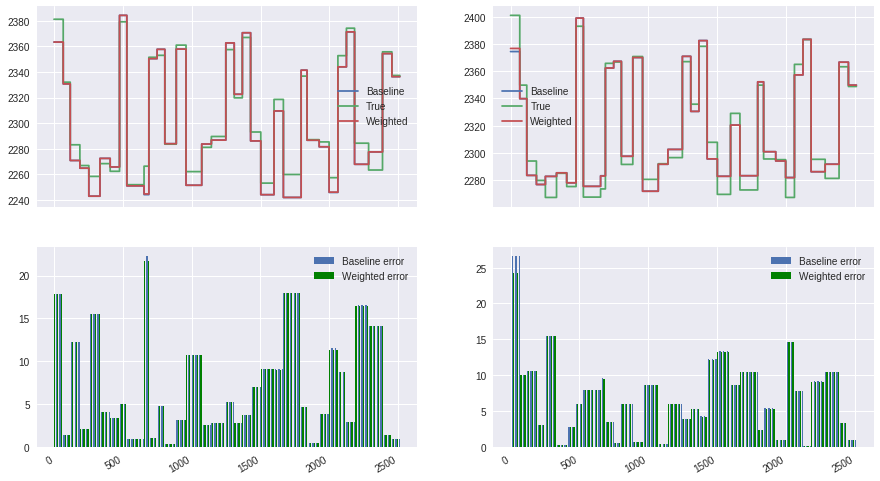

In [73]:
plot_ticker(predicted)